In [152]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import  GridSearchCV
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
import lightgbm as lgb
import joblib
#from scipy.sparse import csr_matrix

In [153]:
# Load datasets
train_df = pd.read_csv("C:/GitHub/Machine-Learning/INF1279H/train_data.csv")
test_df = pd.read_csv("C:/GitHub/Machine-Learning/INF1279H/test_data.csv")

In [154]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18788 entries, 0 to 18787
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Clothing ID              18788 non-null  int64 
 1   Age                      18788 non-null  int64 
 2   Title                    15726 non-null  object
 3   Review Text              18088 non-null  object
 4   Rating                   18788 non-null  int64 
 5   Recommended IND          18788 non-null  int64 
 6   Positive Feedback Count  18788 non-null  int64 
 7   Division Name            18776 non-null  object
 8   Department Name          18776 non-null  object
 9   Class Name               18776 non-null  object
dtypes: int64(5), object(5)
memory usage: 1.4+ MB


In [ ]:
# Drop unnecessary columns (Clothing ID - not useful for prediction)
train_df.drop(columns=["Clothing ID"], inplace=True) # 
test_df.drop(columns=["Clothing ID"], inplace=True)

In [156]:
# Handle missing values to prevent error in TF_IDF technique
imputer = SimpleImputer(strategy='most_frequent')
train_df["Title"] = train_df["Title"].fillna("")
train_df["Review Text"] = train_df["Review Text"].fillna("")
test_df["Title"]=test_df["Title"].fillna("")
test_df["Review Text"]= test_df["Review Text"].fillna("")

In [157]:
# Encode categorical features
label_encoders = {}
categorical_cols = ["Division Name", "Department Name", "Class Name"]

for col in categorical_cols:
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col].astype(str))
    
    # Handle unseen categories in test set
    test_df[col] = test_df[col].astype(str).map(lambda x: le.transform([x])[0] if x in le.classes_ else -1)
    
    label_encoders[col] = le

#print(train_df.head())
#print(label_encoders)

In [158]:
# Convert text data into TF-IDF features
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
train_tfidf = tfidf_vectorizer.fit_transform(train_df["Review Text"] + " " + train_df["Title"])
test_tfidf = tfidf_vectorizer.transform(test_df["Review Text"] + " " + test_df["Title"])

In [ ]:
# Define features and target
X_train = hstack((train_tfidf, train_df.drop(columns=["Review Text", "Title", "Rating", "Recommended IND"]))) 

y_train = train_df["Recommended IND"]
X_test = hstack((test_tfidf, test_df.drop(columns=["Review Text", "Title", "Rating","Recommended IND"]))) 
y_test = test_df["Recommended IND"]

In [160]:
# Train LightGBM Model with Hyperparameter Tuning
param_grid = {
    'num_leaves': [31, 50, 100],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 500],
    'max_depth': [-1, 10, 20]
}


In [161]:
#Grid Search
lgb_clf = lgb.LGBMClassifier(random_state=42, class_weight='balanced')
grid_search = GridSearchCV(lgb_clf, param_grid, cv=3, scoring='f1_weighted', n_jobs=-1)
grid_search.fit(X_train, y_train)


[LightGBM] [Info] Number of positive: 15467, number of negative: 3321
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.074432 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 103705
[LightGBM] [Info] Number of data points in the train set: 18788, number of used features: 2034
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


GridSearchCV(cv=3,
             estimator=LGBMClassifier(class_weight='balanced', random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [-1, 10, 20],
                         'n_estimators': [100, 200, 500],
                         'num_leaves': [31, 50, 100]},
             scoring='f1_weighted')

In [162]:
print()
print("Best Model Parameters:", grid_search.best_params_)
# Best model
best_lgb = grid_search.best_estimator_

# Save the trained LightGBM model
joblib.dump(best_lgb, "lightgbm_task1_model.pkl")
print("Model saved successfully as lightgbm_task1_model.pkl")


Best Model Parameters: {'learning_rate': 0.05, 'max_depth': -1, 'n_estimators': 500, 'num_leaves': 50}
Model saved successfully as lightgbm_task1_model.pkl


In [163]:


# Convert to DataFrame with feature names
feature_names = [f"feature_{i}" for i in range(X_train.shape[1])]
X_train_df = pd.DataFrame(X_train.toarray(), columns=feature_names)
X_test_df = pd.DataFrame(X_test.toarray(), columns=feature_names)

# Train LightGBM Model
best_lgb.fit(X_train_df, y_train, feature_name=feature_names)


[LightGBM] [Info] Number of positive: 15467, number of negative: 3321
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.079043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 103705
[LightGBM] [Info] Number of data points in the train set: 18788, number of used features: 2034
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


LGBMClassifier(class_weight='balanced', learning_rate=0.05, n_estimators=500,
               num_leaves=50, random_state=42)

In [164]:
# Make Predictions
y_pred = best_lgb.predict(X_test_df)

# Evaluate model (accuracy over test dataset)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print(f"Final Weighted F1-score: {f1_score(y_test, y_pred, average='weighted'):.2f}")

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.73      0.72       851
           1       0.94      0.94      0.94      3847

    accuracy                           0.90      4698
   macro avg       0.83      0.83      0.83      4698
weighted avg       0.90      0.90      0.90      4698

Final Weighted F1-score: 0.90


In [165]:
#accuracyt over the trained data
y_train_pred = best_lgb.predict(X_train_df)
train_f1 = f1_score(y_train, y_train_pred, average='weighted')
print(f"Final Weighted F1-score on training set: {train_f1:.4f}")

Final Weighted F1-score on training set: 0.9905


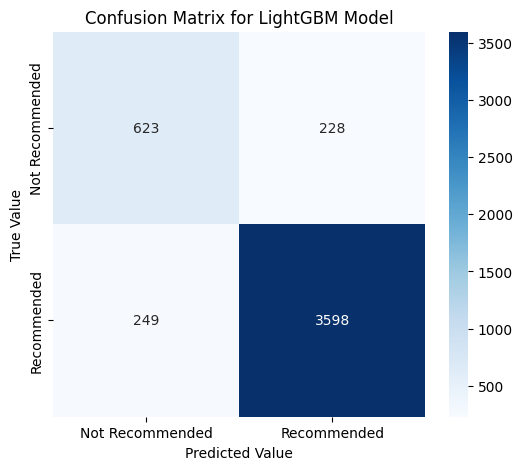

In [166]:
# Visualization - Confusion Matrix
plt.figure(figsize=(6, 5))
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Not Recommended", "Recommended"], yticklabels=["Not Recommended", "Recommended"])
plt.xlabel("Predicted Value")
plt.ylabel("True Value")
plt.title("Confusion Matrix for LightGBM Model")
plt.show()